# Quantum Text Teleportation along with Huffman Compression and Decompression
* Compressing the actual input text file and converting it into binary and stored in ".bin" file.
* Passing Binary values to the Quantum Teleportation circuit.
* Decompressing Teleported Binary values into actual file.

In [1]:
import heapq
import os
import time
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
import warnings
warnings.filterwarnings("ignore")

class BinaryTree:
    def __init__(self,value,frequ):
        self.value = value
        self.frequ = frequ
        self.left = None
        self.right = None
        
    def __lt__(self,other):
        # Overloadinf the function
        return self.frequ < other.frequ
    
    def __eq__(self,other):
        # Overloadinf the function
        return self.frequ == other.frequ        

class Huffmancode:
    
    def __init__(self,path):
        self.path = path
        self.__heap = []
        self.__code = {}
        self.__reversecode = {}
        
    def __frequency_from_text(self,text):
        # Private fuction
        frequ_dict = {}
        for char in text:
            if char not in frequ_dict:
                frequ_dict[char] = 0
            frequ_dict[char] +=1
        return frequ_dict    
    
    def __Build_heap(self,frequency_dict):
        # Private fuction
        for key in frequency_dict:
            frequency = frequency_dict[key]
            binary_tree_node = BinaryTree(key,frequency)
            heapq.heappush(self.__heap , binary_tree_node)
    
    def __Build_Binary_Tree(self):
        # Private fuction
        while len(self.__heap) > 1:
            binary_tree_node_1 = heapq.heappop(self.__heap)
            binary_tree_node_2 = heapq.heappop(self.__heap)
            sum_of_freq = binary_tree_node_1.frequ + binary_tree_node_2.frequ
            newnode = BinaryTree(None,sum_of_freq)
            # Create connections between these nodes
            newnode.left = binary_tree_node_1
            newnode.right = binary_tree_node_2
            heapq.heappush(self.__heap,newnode)
        return
    
    def __Build_Tree_Code_Helper(self,root,curr_bits):
        # Private fuction
        if root is None:
            return
        if root.value is not None:
            self.__code[root.value] = curr_bits
            self.__reversecode[curr_bits] = root.value
            return
        self.__Build_Tree_Code_Helper(root.left,curr_bits+'0')
        self.__Build_Tree_Code_Helper(root.right,curr_bits+'1')
    
    def __Build_Tree_Code(self):
        # Private fuction
        root = heapq.heappop(self.__heap)
        self.__Build_Tree_Code_Helper(root,'')
        

    def __Build_Encoded_Text(self,text):
        # Private fuction
        encoded_text = ''
        for char in text:
            encoded_text += self.__code[char]
            
        return encoded_text  
    
    
    def __Build_Padded_Text(self,encoded_text):
        # Private fuction
        # We have a formula to get len of thhe padded text and that is,
        # 8 - (len of the encoded_text % 8)
        padding_value = 8 - (len(encoded_text) % 8)
        for i in range(padding_value):
            encoded_text += '0'
        # Getting padded strings information - number of padded strings used.    
        padded_info = "{0:08b}".format(padding_value)
        padded_encoded_text = padded_info + encoded_text
        return padded_encoded_text
    
    def __Build_Byte_Array(self, padded_text):
        # Private fuction
        array = []
        for i in range(0,len(padded_text) , 8):
            byte = padded_text[i:i+8]
            array.append(int(byte,2))
        return array    
    
    def compression(self):
        
        #To access the file and extract text from that file.
        filename,file_extension = os.path.splitext(self.path)
        output_path = filename + '.bin'
        with open (self.path,'r+') as file , open(output_path,'wb') as output:
            text = file.read()
            text = text.rstrip()
            
            #Calculate frequency of each text and store it in freq. dictionary
            
            frequency_dict = self.__frequency_from_text(text)

            # Min heap for two minimum frquency.

            build_heap = self.__Build_heap(frequency_dict)

            #Construct binary tree from Heap .

            self.__Build_Binary_Tree()

            #construct code from binary tree and stored it in dictionary.

            self.__Build_Tree_Code()

            #Construct encoded text.

            encoded_text = self.__Build_Encoded_Text(text)

            #padding of text

            padded_text = self.__Build_Padded_Text(encoded_text)

            #We have to return that binary file as an output.

            bytes_array = self.__Build_Byte_Array(padded_text)

            final_bytes = bytes(bytes_array)
            output.write(final_bytes)
        print("Successfully Compressed...")
        return output_path

    def getting_binary_values(self, input_path):
        filename,file_extension = os.path.splitext(input_path)
        with open(input_path,'rb') as file:
            bit_string = ''
            # Read one byte by one byte and so on...
            byte = file.read(1)
            while byte:
                # Convert Hexa decimal to integer by using ord()
                byte = ord(byte)
                # Convert integer to binary as b'011
                # But we need to ingnore b' from b'011. So we use slicing
                # and finally we make it to 8 bits by using rjust()
                bits = bin(byte)[2:].rjust(8,'0')
                bit_string += bits
                byte = file.read(1)
        return(bit_string)
    
    
    def __Remove_Padding(self,text):
        # Private fuction
        padded_info = text[:8]
        extra_padding = int(padded_info,2)
        text = text[8:]
        padding_removed_text = text[:-1*extra_padding]
        return padding_removed_text
        
    def __Decompress_Text(self,text):
        # Private fuction
        decoded_text = ''
        current_bits = ''
        for bit in text:
            current_bits += bit
            if current_bits in self.__reversecode:
                character = self.__reversecode[current_bits]
                decoded_text += character
                current_bits = ""
        return decoded_text
    
    
    def decompress(self,input_path, teleported_bits_string):
        filename,file_extension = os.path.splitext(input_path)
        output_path = filename + '_decompressed' + '.txt'
        with open(output_path,'w') as output:
            actual_text = self.__Remove_Padding(teleported_bits_string)
            decompressed_text = self.__Decompress_Text(actual_text)
            output.write(decompressed_text)
        print('\nSuccessfully Decompressed...')
        return    
    
    def QFTP(self, binary_list):
        
        # starting time
        start = time.time()
        # program body starts
        
        ''' aD --- represents --- Alice Data Qubit
            aQ --- represents --- Alice Qubit
            bQ --- represents --- Bob Data Qubit '''

        print('\nTeleportation started...')
        count = 0
        counts_list = []
        t = 1
        for each in binary_list:
            single_char = each 
            n = len(single_char)

            Alice_data = QuantumRegister(n, 'aD')
            Alice_qubit = QuantumRegister(n, 'aQ')
            Bob_qubit = QuantumRegister(n, 'bQ')
            cr = ClassicalRegister(n*3, 'c')
            circuit = QuantumCircuit(Alice_data, Alice_qubit, Bob_qubit, cr)

            i = 0
            for each in single_char:
                if(each == '1'):
                    circuit.x(Alice_data[int(i)])
                i += 1
            circuit.barrier()


            for i in range(n):
                circuit.h(Alice_qubit[i])
                circuit.cx(Alice_qubit[i], Bob_qubit[i])
            circuit.barrier()


            for i in range(n):
                circuit.cx(Alice_data[n-1-i], Alice_qubit[n-1-i])
                circuit.h(Alice_data[n-1-i])
            circuit.barrier()


#             for i in range(n):
#                 circuit.measure(Alice_data[i], cr[i])

#             for i in range(n):
#                 circuit.measure(Alice_qubit[i], cr[i])
#             circuit.barrier()


            for i in range(n):
                circuit.cx(Alice_qubit[i], Bob_qubit[i])
                circuit.cz(Alice_data[i], Bob_qubit[i])
            circuit.barrier()


            for i in range(n):
                circuit.measure(Bob_qubit[i], cr[i])

            # circuit.draw(output = 'mpl')

            ''' Getting counts from backend '''
            simulator_backend = Aer.get_backend('qasm_simulator')
            result = execute(circuit, simulator_backend, shots = 1).result()
            counts = result.get_counts()


            for key in counts:
                key_var = key
                a = key_var[len(key_var)-n:]
                b = ''
                for i in range(len(a)):
                    b = b + a[(-i-1)]
                counts_list.append(b)

            # print('.', end = '')
            print(f'\rOut of |{len(binary_list)}| Iterartions, |{t}| Iterations completed', end="")
            t += 1
            count += 1
        
        # print("\nDot's is : ", count)
        # program body ends
        # end time
        end = time.time()
        # total time taken
        print(f"\nRuntime of the Circuit is |{end - start}| Seconds")
        
        print('\nProcess completed !')

        print('\nHurray!😊 you have successfully Teleporated entire File using Quantum Teleportation.')
        return counts_list

In [2]:
# Reading a File
path = input("Enter the Path of Your File : ")   
h = Huffmancode(path)

# Compression of the file and getting compressed ".bin" file path as output_path
output_path = h.compression()

# Getting the Binary values of the Compressed file and Creating a list each with 8 bits
bits_string = h.getting_binary_values(output_path)

binary_list =[]
string = ''
for each in bits_string:
    string += each
    if len(string) == 2: # 8 qubits for each
        binary_list.append(string)
        string = ''

# Passing compressed file Binary List to the "Quantum Teleportation Circuit". 
print('\nNumber of Iterations : ', len(binary_list))
output_binary_list = h.QFTP(binary_list)


# Converting Teleported binary list into a single list for Decompression.
teleported_bits_string = ''
for each in binary_list:
    teleported_bits_string += each

# Decompression of the file and storing it in new file -- "input_filename_decompressed.txt"
h.decompress(output_path, teleported_bits_string)

Enter the Path of Your File :  sample text.txt


Successfully Compressed...

Number of Iterations :  180

Teleportation started...
Out of |180| Iterartions, |180| Iterations completed
Runtime of the Circuit is |3.202680826187134| Seconds

Process completed !

Hurray!😊 you have successfully Teleporated entire File using Quantum Teleportation.

Successfully Decompressed...


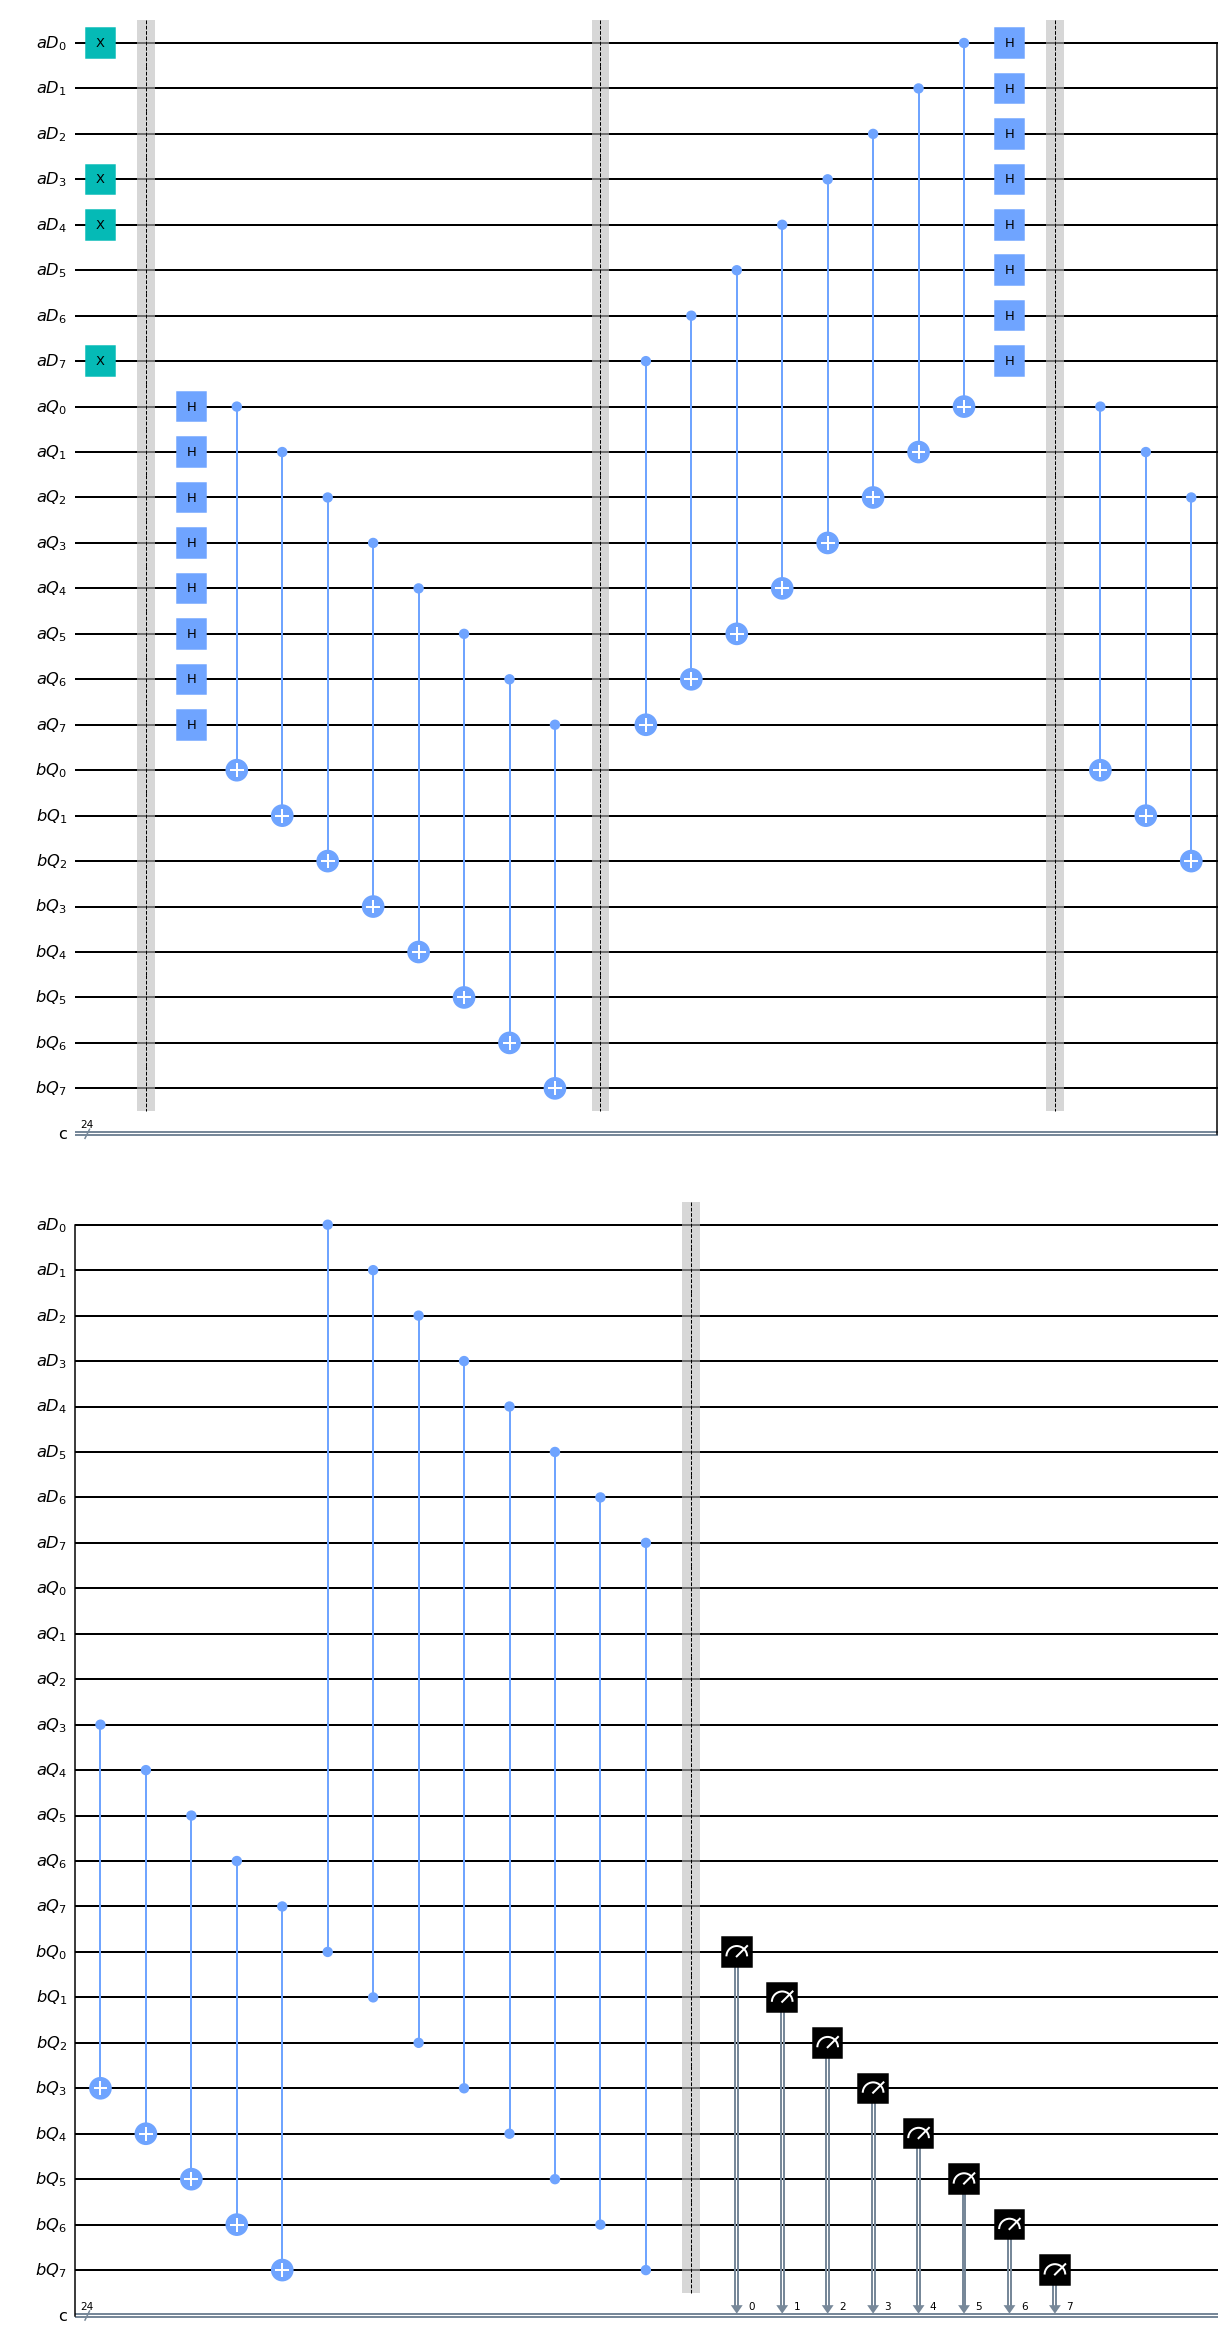

In [3]:
single_char = '10011001' 
n = len(single_char)

Alice_data = QuantumRegister(n, 'aD')
Alice_qubit = QuantumRegister(n, 'aQ')
Bob_qubit = QuantumRegister(n, 'bQ')
cr = ClassicalRegister(n*3, 'c')
circuit = QuantumCircuit(Alice_data, Alice_qubit, Bob_qubit, cr)

i = 0
for each in single_char:
    if(each == '1'):
        circuit.x(Alice_data[int(i)])
    i += 1
circuit.barrier()


for i in range(n):
    circuit.h(Alice_qubit[i])
    circuit.cx(Alice_qubit[i], Bob_qubit[i])
circuit.barrier()


for i in range(n):
    circuit.cx(Alice_data[n-1-i], Alice_qubit[n-1-i])
    circuit.h(Alice_data[n-1-i])
circuit.barrier()


for i in range(n):
    circuit.cx(Alice_qubit[i], Bob_qubit[i])
    circuit.cz(Alice_data[i], Bob_qubit[i])
circuit.barrier()


for i in range(n):
    circuit.measure(Bob_qubit[i], cr[i])

circuit.draw(output = 'mpl')